# HW5: Database - Weather Prediction


In this assignment, we will create a database to analyze historical weather data and discover the relationships between major cities.

**This file would complete the last two tasks as to analyze the data we have obtained before. For quicker references, the correlation values would be calculated and saved as another table in the same database.**

1. Refer to database_construction.db
2. Refer to database_construction.db
3. Refer to database_construction.db
4. For each pair of cities/airports, determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, and 7 days in advance.
5. Plot the correlation strengths for the 10 top pairs for all three dates for temperature and precipitation (separately) as a function of distance. Also, make a plot as a function of longitude. What trends do you see?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import *
from sqlalchemy.sql import select
import seaborn as sns
from itertools import permutations
from tqdm import tqdm
sns.set_style('white')
sns.set_context('poster')
sns.set_color_codes()
%matplotlib inline

**For each pair of cities/airports, determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, and 7 days in advance.**

Essentially, we are about to find the correlations between weather data of cities. First load the database tables that were populated before in top_50_airports.db, then calculate correlations, save the correlation values in another table and write into the same database.

In [2]:
engine = create_engine('sqlite:///top_50_airports.db')
connection = engine.connect()
meta = MetaData()
weather = Table('weather', meta, autoload=True, autoload_with=engine)
airports = Table('top_50_airports', meta, autoload=True, autoload_with=engine)

In [3]:
def correlate_high_temp(icao1, icao2, dt):
    """
    Calculates the correlation coefficient of the temperature high difference
    between airports icao1 & icao2 with dt days delayed in icao2 (or dt days in advance in icao1).
    """
    sel = select([weather.c.max_temp, weather.c.date])
    loc1 = sel.where(weather.c.icao.like(icao1))
    loc2 = sel.where(weather.c.icao.like(icao2))
    th1 = np.array([th[0] for th in connection.execute(loc1)])
    th2 = np.array([th[0] for th in connection.execute(loc2)])
    # Replace nan with zero and inf with large finite numbers
    # th1 = np.nan_to_num(th1)
    # th2 = np.nan_to_num(th2)
    data = list(zip(*[th1, th2]))
    df = pd.DataFrame(data=data, 
                      columns=[icao1, icao2],
                      dtype=(float, float))
    df = df.fillna(0.01)
    cor_coef = np.corrcoef(np.array(df[icao1].diff(1).bfill()), np.array(df[icao2].diff(1).shift(dt).bfill()))[0,1]
    
    """
    numpy.float64 object does not support item assignment
    I could not fix this missing value issue. Fillna does not work in my method.
    """ 
    # where_are_NaNs = np.isnan(cor_coef)
    # cor_coef[where_are_NaNs] = 0
    # cor_coef[np.where(np.isnan(cor_coef) == np.nan)] = 0
    return cor_coef

In [4]:
def correlate_precip(icao1, icao2, dt):
    """
    Calculates the correlation coefficient of the precipitation difference
    between airports icao1 & icao2 with dt days delayed in icao2 (or dt days in advance in icao1).
    """
    sel = select([weather.c.precip, weather.c.date])
    loc1 = sel.where(weather.c.icao.like(icao1))
    loc2 = sel.where(weather.c.icao.like(icao2))
    p1 = np.array([p[0] for p in connection.execute(loc1)])
    p2 = np.array([p[0] for p in connection.execute(loc2)])
    # Replace nan with zero and inf with large finite numbers
    p1 = np.nan_to_num(p1)
    p2 = np.nan_to_num(p2)
    data = list(zip(*[p1, p2]))    
    df = pd.DataFrame(data=data,
                      columns=[icao1, icao2],
                      dtype=(float, float))
    df = df.fillna(0.01)
    cor_coef = np.corrcoef(np.array(df[icao1].diff(1).bfill()), np.array(df[icao2].diff(1).shift(dt).bfill()))[0,1]
    """
    numpy.float64 object does not support item assignment
    I could not fix this missing value issue. Fillna does not work in my method.
    """ 
    # where_are_NaNs = np.isnan(cor_coef)
    # cor_coef[where_are_NaNs] = 0
    # cor_coef[np.where(np.isnan(cor_coef) == np.nan)] = 0
    return cor_coef

Create a new table in the database to hold all the correlation data.

In [5]:
meta = MetaData()
corr_table = Table('correlations', meta,
                   Column('icao1', String),
                   Column('icao2', String),
                   Column('high_temp_1', Float),
                   Column('high_temp_3', Float),
                   Column('high_temp_7', Float),
                   Column('precip_1', Float),
                   Column('precip_3', Float),
                   Column('precip_7', Float), extend_existing=True)

Now populate the database for all pairs of airports in the correlation table

In [6]:
airport_list = [r[0] for r in connection.execute(select([airports.c.ICAO]))]

Now we fill this new table iterating through all pairs of airports


In [7]:
pairs = list(permutations(airport_list, 2))
for p in tqdm(pairs):
    th1 = correlate_high_temp(p[0], p[1], 1)
    th3 = correlate_high_temp(p[0], p[1], 3)
    th7 = correlate_high_temp(p[0], p[1], 7)
    p1 = correlate_precip(p[0], p[1], 1)
    p3 = correlate_precip(p[0], p[1], 3)
    p7 = correlate_precip(p[0], p[1], 7)
    corrs = corr_table.insert().values(icao1=p[0], 
                                       icao2=p[1],
                                       high_temp_1=th1,
                                       high_temp_3=th3,
                                       high_temp_7=th7,
                                       precip_1=p1,
                                       precip_3=p3,
                                       precip_7=p7)
    connection.execute(corrs)

  0%|          | 0/2450 [00:00<?, ?it/s]/Users/leoli/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/leoli/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/leoli/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/leoli/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/leoli/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
100%|██████████| 2450/2450 [00:27<00:00, 89.22it/s]


The above warning issue in red block influences all the plotting below, as all correlation values are calculated/resulted as 'NONE' values. Below are the functions needed to generate the plots, but the actually plots are all empty as there are no correlations.

In [8]:
def get_lat_long(icao):
    """
    Get the latitude and longitude of an airport
    """
    sel = select([airports.c.latitude_deg, airports.c.longitude_deg])
    q = sel.where(airports.c.ICAO.like(icao))
    q = q.order_by(func.abs(airports.c.longitude_deg))
    results = connection.execute(q).fetchall()
    return results[0]

In [9]:
def get_dlat_dlong(icao1, icao2):
    """
    Get the differences in latitude and longitude between two airports
    """
    lat1, long1 = get_lat_long(icao1)
    lat2, long2 = get_lat_long(icao2)
    return lat1-lat2, long1-long2

In [10]:
# This function is correct and works
get_dlat_dlong('KEWR', 'KJFK')

(0.052700038115197856, -0.38980102187500165)

In [11]:
def get_distance(icao1, icao2):
    """
    Use the Haversine formula to calculate the distance between two airports
    """
    lat1, long1 = np.deg2rad(get_lat_long(icao1))
    lat2, long2 = np.deg2rad(get_lat_long(icao2))
    # Use Haversine formula to obtain distances
    a = np.sin((lat2-lat1)/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2.)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.-a))
    R = 6371 # Earth's radius in km
    d = R * c
    return d

In [12]:
# This function is correct and works
get_distance('KORD', 'KSFO')

2963.9631560481826

In [13]:
def get_top(col_name, n=0):
    """
    Get the airport ICAO codes and correlation coefficients of col_name (one of high_temp_x or precip_x for 
    x in 1, 3, 7) for the n pairs with the largest correlations or anti-correlations. Results are sorted by
    the absolute value of the correlation coefficient in ascending order.
    """
    sel = select([corr_table.c.icao1, corr_table.c.icao2, corr_table.c.get(col_name)])
    q = sel.order_by(func.abs(corr_table.c.get(col_name)))
    results = connection.execute(q).fetchall()
    return results[-n:]

In [14]:
get_top('high_temp_1', n = 10)

[('KIND', 'KHOU', None),
 ('KIND', 'KSNA', None),
 ('KIND', 'KAUS', None),
 ('KIND', 'KSJC', None),
 ('KIND', 'KMSY', None),
 ('KIND', 'KPIT', None),
 ('KIND', 'KSAT', None),
 ('KIND', 'KCVG', None),
 ('KIND', 'KMKE', None),
 ('KIND', 'KDAL', None)]

As seen here, the correlations are all 'NONE'. I could not fix this issue; consequently, I couldn't generate any plots, since correlations are missing so plots are all empty. Below is a function that ideally should work to generate 6 plots (1, 3 & 7 days correlations as a function of distance & longitude difference) for the top 10 pairs of airports

In [15]:
def plot(col_name, n=0, title='', save=None):
    """
    Plots of correlation coefficients for col_name as functions of distance and longitude difference.
    """
    icao1, icao2, corr = zip(*get_top(col_name, n))
    pairs = list(zip(icao1, icao2))
    dist = [get_distance(*p) for p in pairs]
    dlat, dlong = list(zip(*[get_dlat_dlong(*p) for p in pairs]))
    plt.figure(figsize=(12, 15))
    plt.subplot(211)
    plt.scatter(dist, corr)
    plt.title(title)
    plt.xlim(0, 10000)
    plt.xlabel('Distance (km)')
    plt.ylabel('Correlation coefficent')
    plt.subplot(212)
    plt.scatter(dlong, corr)
    plt.xlabel('$\Delta$ longitude (degrees)')
    plt.ylabel('Correlation coefficent')

    if save is not None:
        plt.savefig(save, bbox_inches='tight')

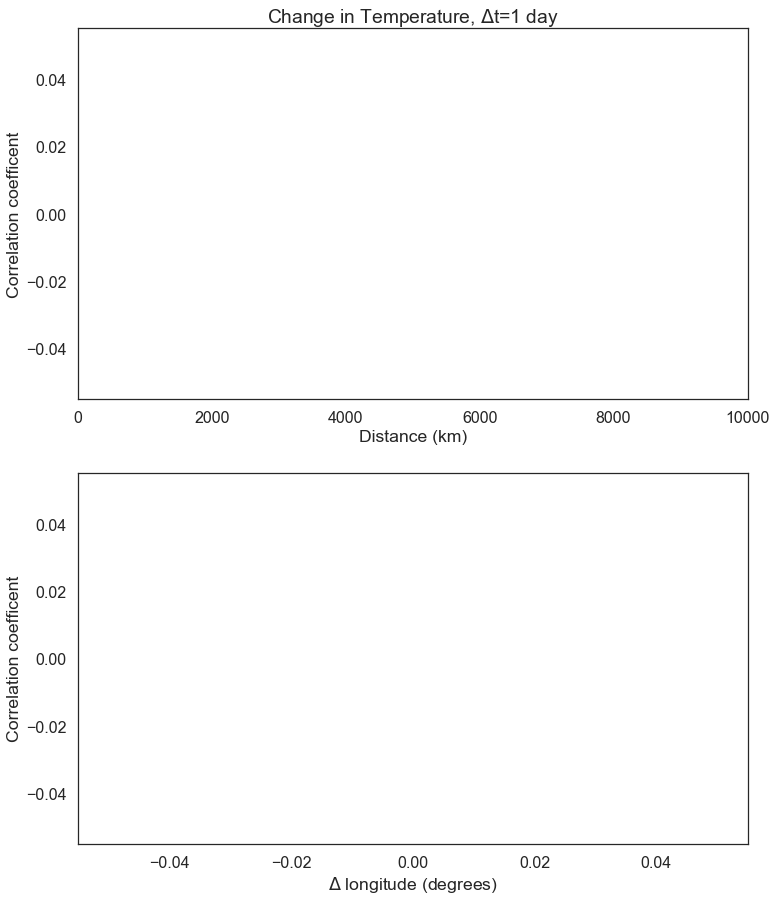

In [16]:
plot(col_name = 'high_temp_1', title='Change in Temperature, $\Delta$t=1 day', n=10)

In [ ]:
plot(col_name = 'high_temp_3', title='Change in Temperature, $\Delta$t=3 day', n=10)

In [ ]:
plot(col_name = 'high_temp_7', title='Change in Temperature, $\Delta$t=7 day', n=10)

In [ ]:
plot(col_name = 'precip_1', title='Change in Precipitation, $\Delta$t=1 day', n=10)

In [ ]:
plot(col_name = 'precip_3', title='Change in Precipitation, $\Delta$t=3 day', n=10)

In [ ]:
plot(col_name = 'precip_7', title='Change in Precipitation, $\Delta$t=7 day', n=10)